# EE 519 — Speech AI 
## HW-1 | Notebook 3: Time Operations — Delay, Echo, Reversal (Global & Short-Time)

**Student Name:**  Kobe Kodachi

**USC ID:**  7134744658

**Date:**  2/3/2026

---

### Learning Objectives
By completing this notebook, you will:
- Apply **time-domain operations** to speech (delay, echo, reversal)
- Connect time operations to perceptual effects (echo vs reverb-like smear)
- Compare **global time reversal** vs **short-time reversal**
- Develop intuition for **short-time processing** and (approx.) stationarity in speech

> ⚠️ **Important**
> - All answers (code + explanations) must be written **inside this notebook**
> - Do **not** delete questions or prompts
> - Clearly label all plots (title, axes, units)
> - Audio must be playable inline where requested


### Grading (Notebook 3 — 20 points)

| Component | Points |
|---|---:|
| Reproducible audio setup + clean I/O | 3 |
| Delay + echo experiments (plots + listening) | 6 |
| Global reversal analysis (plots + explanation) | 4 |
| Short-time reversal analysis (plots + explanation) | 5 |
| Clarity, organization, reflections | 2 |

> We grade **understanding and reasoning**, not perfection.


---

# 0. Setup

This notebook must run **quickly and reproducibly** for grading.

## ✅ Reproducibility requirements (very important)
- Put audio files in the **same folder as this notebook** or inside `./audio/`
- Use **relative paths only**
- Do not rely on cloud mounts or absolute paths
- Notebook should run top-to-bottom after we download your ZIP

Recommended structure:
```
HW1/
├── HW1_Notebook3_Time_Operations_Echo_Reversal.ipynb
└── audio/
    └── x.wav
```

## Data requirement
You need **one** speech recording `x` (sentence recommended).
You may:
- Record it in Python (optional) and save to `./audio/x.wav`, OR
- Record externally and place it at `./audio/x.wav`


In [1]:
# TODO: Libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

import os
from scipy.io import wavfile

In [2]:
# TODO: Path (use relative paths only)
X_PATH = "./audio/x.wav"


In [ ]:
# OPTIONAL recording (only if your system supports it):
# If recording doesn't work, skip this and use an external WAV file.
#
# !pip install sounddevice soundfile  # (uncomment if needed/allowed)
# import sounddevice as sd
# import soundfile as sf
# from pathlib import Path
#
# Path("./audio").mkdir(exist_ok=True)
# fs_rec = 16000
# duration_sec = 5
# print("Recording... Speak your sentence now.")
# x = sd.rec(int(duration_sec*fs_rec), samplerate=fs_rec, channels=1)
# sd.wait()
# x = x.squeeze()
# sf.write("./audio/x.wav", x, fs_rec)
# print("Saved to ./audio/x.wav")


In [3]:
# TODO: Implement or reuse WAV loader (mono float in [-1, 1])
def to_mono(x):
    """Ensure mono float32 in [-1, 1]."""
    x = np.asarray(x)
    if x.ndim == 2:  # stereo -> mono
        x = x.mean(axis=1)
    if np.issubdtype(x.dtype, np.integer):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
    return np.clip(x, -1.0, 1.0)

def load_wav(path):
    if not os.path.exists(path):
        # print(f"File not found: {path}\nUpload a WAV and update wav_path.")
        raise FileNotFoundError(f"File not found: {path}")
    else:
        fs, x = wavfile.read(path)
        x = to_mono(x)
        print("Loaded:", path)
        print("Sampling rate (Hz):", fs)
        print("Duration (s):", len(x)/fs)
        print(f"Min/max amplitude: {x.min():.3f}/{x.max():.3f}")
        return x, fs

In [4]:
# TODO: Load signal
x, fs = load_wav(X_PATH)
print(fs, len(x)/fs, x.min(), x.max())
display(Audio(x, rate=fs))


Loaded: ./audio/x.wav
Sampling rate (Hz): 16000
Duration (s): 4.0
Min/max amplitude: -0.648/1.000
16000 4.0 -0.6476028 1.0


In [5]:
# TODO: Helper functions
def plot_waveform(x, fs, title, tlim=None):
    # raise NotImplementedError
    t = np.arange(len(x)) / fs
    plt.figure()
    plt.plot(t, x, linewidth=0.8)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")    
    plt.title(title)
    if tlim is not None:
        plt.xlim(tlim)
    plt.show()

def play_audio(x, fs):
    display(Audio(x, rate=fs))

def magnitude_spectrum(x, fs):
    """Return f (Hz) and magnitude (dB or linear)."""
    # raise NotImplementedError
    n = len(x)
    x_w = x * np.hanning(n).astype(np.float32)

    # compute fft and freq axis
    X = np.fft.rfft(x_w)
    freqs = np.fft.rfftfreq(n, d=1/fs)
    mag = 20*np.log10(np.abs(X) + 1e-12)
    return freqs, mag


---

# 1. Time Delay and Echo (Single-Tap FIR Intuition)

An **echo** can be created by adding a delayed and scaled copy of the signal:

\[
y[n] = x[n] + \alpha x[n-D]
\]

Where:
- \(D\) is the delay in samples (e.g., 50 ms, 100 ms, 300 ms)
- \(\alpha\) is the echo gain (e.g., 0.2–0.7)

### Task
Create echoes with delays:
- 50 ms
- 100 ms
- 300 ms

For each delay, test at least **two** gains (e.g., 0.3 and 0.6).


In [ ]:
# TODO: Implement delay operator
def delay_signal(x, D):
    """Delay by D samples: y[n] = x[n-D] with zero padding."""
    # raise NotImplementedError
    y = np.zeros_like(x)
    y[D:] = x[:-D]
    return y

In [14]:
# TODO: Implement echo creator
def add_echo(x, fs, delay_ms, alpha):
    """Return echoed signal y = x + alpha * delayed(x)."""
    # raise NotImplementedError
    D = int(round(delay_ms * fs / 1000))
    y = x + alpha * delay_signal(x,D)
    return y / (np.max(np.abs(y)) + 1e-12)


In [15]:
# TODO: Run echo experiments
delays_ms = [50, 100, 300]
alphas = [0.3, 0.6]
results = {}  # e.g., results[(delay_ms, alpha)] = y
for d in delays_ms:
    for a in alphas:
        results[(d,a)] = add_echo(x,fs,d,a)


## 1.1 Visualize echoes

For at least one region containing speech:
- Plot original and echoed signal (overlay) for each condition
- Use the same time window for fair comparison


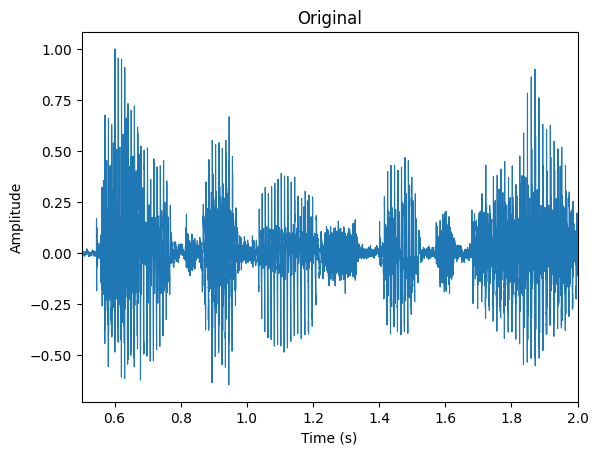

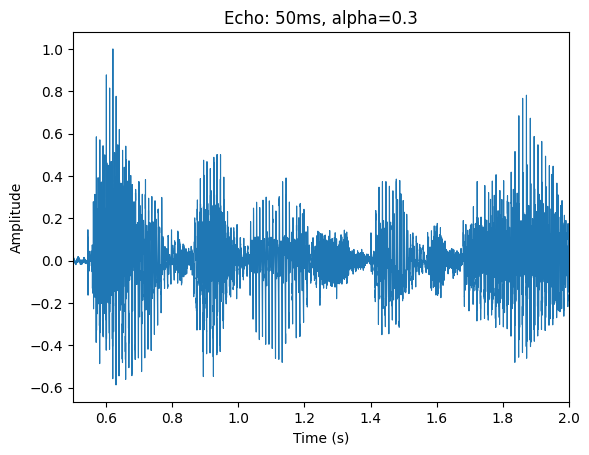

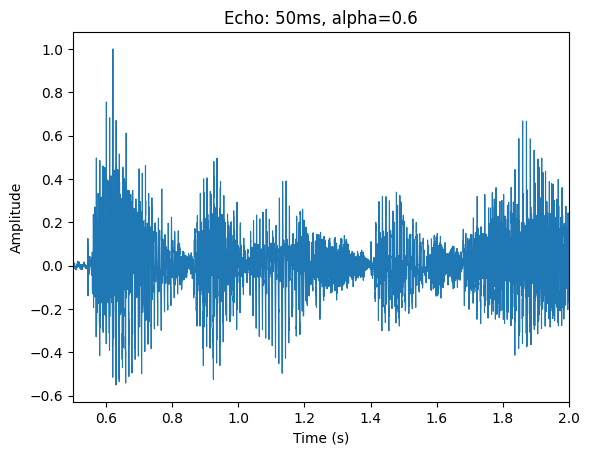

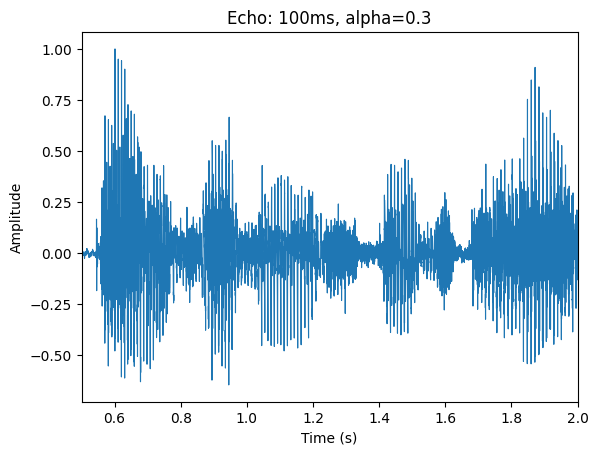

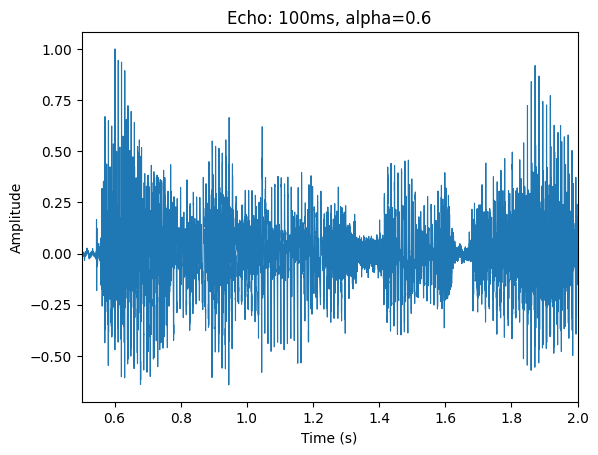

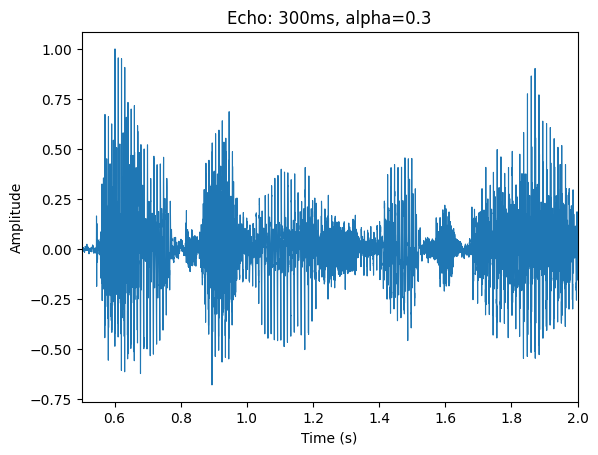

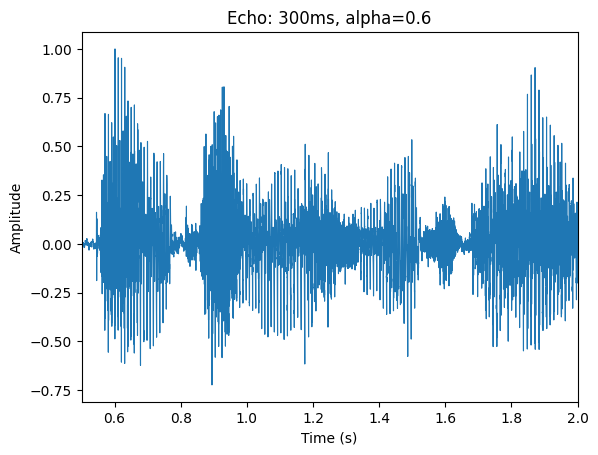

In [16]:
# TODO: Plot overlays for echo conditions
# Pick a time window: (t_start, t_end)
plot_waveform(x, fs, "Original", tlim=(0.5, 2.0))
for (delay_ms, alpha), y in results.items():
    plot_waveform(y, fs, f"Echo: {delay_ms}ms, alpha={alpha}", tlim=(0.5, 2.0))


## 1.2 Listen: echo vs reverb-like smear

Play each echoed version and describe:
- When does the echo become a distinct repetition?
- When does it feel like “thickening”/reverberation instead?

> Use headphones if possible.


### Answers

- After 300 ms is sounds like distinction repetition.
- 50 ms sounds like reverberation.

In [17]:
# TODO: Listening test
for (delay_ms, alpha), y in results.items():
    print(f"Echo: {delay_ms} ms, alpha={alpha}")
    play_audio(y, fs)


Echo: 50 ms, alpha=0.3


Echo: 50 ms, alpha=0.6


Echo: 100 ms, alpha=0.3


Echo: 100 ms, alpha=0.6


Echo: 300 ms, alpha=0.3


Echo: 300 ms, alpha=0.6


### Observations (Echo)

Answer in 8–12 lines total:

- Which delay/gain combination sounded like a **distinct echo**?
- Which combinations sounded more like **reverb / thickening**?
- What role does \(\alpha\) play perceptually?
- Did any condition cause clipping? If yes, how did you handle it?


### Answers

- The 100 ms, 60 alpha sounded the most like a distinct echo.
- Both 50 ms signals sounded like reverb/thickening. This is because the delay wasn't long enough.
- Alpha controls both loud the echo should be compared to the original signal. In this homework we use 30% and 60%.
- There was clipping which can occur with a worst case of 1 + alpha. I solved this by normalizing after adding the echo.

---

# 2. Global Time Reversal

Global time reversal is:
\[
y[n] = x[-n]
\]
In discrete time (finite signals), reversing the array implements this.

### Task
- Create a fully time-reversed version of your speech signal
- Compare waveform, spectrum, and intelligibility


In [18]:
# TODO: Global reversal
y_rev = x[::-1]


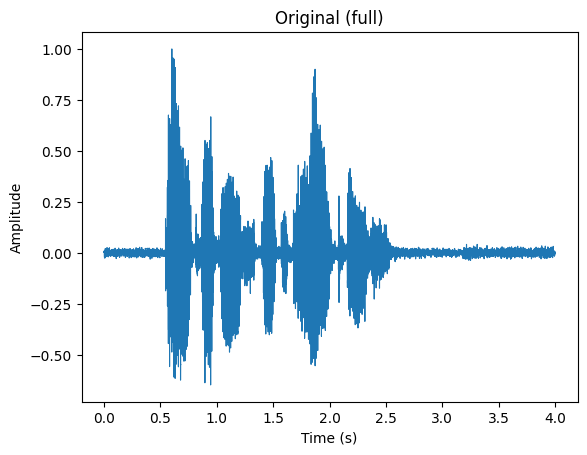

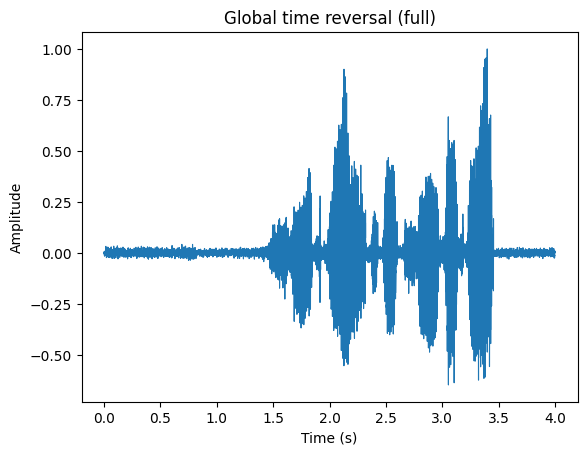

In [20]:
# TODO: Plot + play global reversal
plot_waveform(x, fs, "Original (full)")
plot_waveform(y_rev, fs, "Global time reversal (full)")
play_audio(y_rev, fs)


### Conceptual Questions (Global Reversal)

Answer clearly in complete sentences:

1. Is the reversed speech intelligible? Why or why not?  
2. Which properties remain the same after reversal (duration, energy distribution, magnitude spectrum)?  
3. Which properties fundamentally change (temporal cues, attack/decay patterns, coarticulation cues)?  
4. Does the **magnitude spectrum** change under reversal? (Explain.)


### Answers

1. It is not intelligible at all. We rely on the order of the signal so changing the temporal order will ruin the speech.
2. The duration, energy distribution, and magnitude spectrum all remain unaffected by reversal since magnitude is unaffected. We also don't trim the audio.
3. Temporal cues are fundamentally changed since they are reversed. Attack/decay pattern sound unnatural since humans don't produce sounds such as vowels backwards. Coarticulation cues are destroyed because humans naturally blend the sounds when producing speech forward in time.
4. Magnitude spectrum does not change since it does not depend on temporal order.


---

# 3. Short-Time Reversal (Windowed / Local Reversal)

In short-time processing, we operate on short frames (e.g., 20–30 ms).
Short-time reversal reverses samples **within each frame**, while frame order remains unchanged.

### Task
Implement short-time reversal with:
- 20 ms frames
- 30 ms frames
Use a hop size equal to the frame size (non-overlapping) for simplicity.

> Optional extension: try overlapping frames with a window and overlap-add.


In [21]:
# TODO: Implement short-time reversal
def short_time_reverse(x, fs, frame_ms):
    """Reverse samples within each frame of length frame_ms (non-overlapping)."""
    # raise NotImplementedError
    frame_len = int(round(frame_ms * fs / 1000))
    y = np.zeros_like(x)

    for start in range(0, len(x), frame_len):
        end = min(start + frame_len, len(x))
        y[start:end] = x[start:end][::-1]

    return y

In [22]:
# TODO: Generate short-time reversed signals
y_str_20 = short_time_reverse(x, fs, frame_ms=20)
y_str_30 = short_time_reverse(x, fs, frame_ms=30)


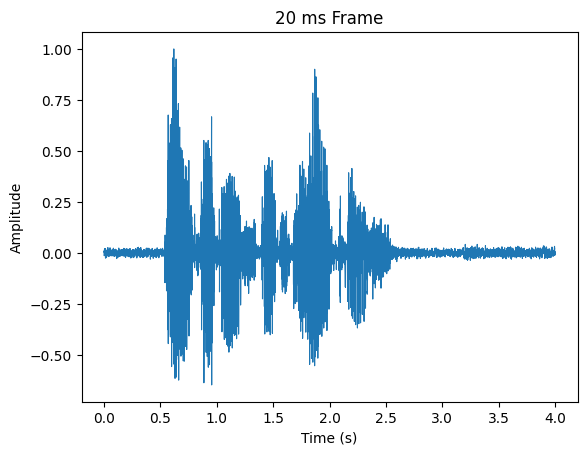

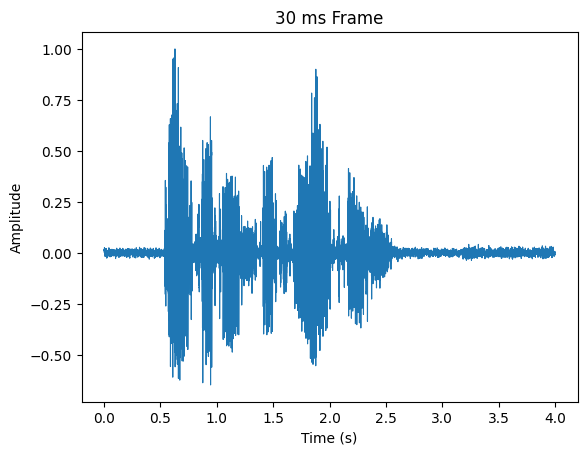

In [23]:
# TODO: Plot + play short-time reversal outputs
play_audio(y_str_20, fs)
play_audio(y_str_30, fs)
# Plot a segment for comparison
plot_waveform(y_str_20,fs,"20 ms Frame")
plot_waveform(y_str_30,fs,"30 ms Frame")


## 3.1 Spectrogram comparison (recommended)

Compute and plot spectrograms for:
- Original
- Global reversal
- 20 ms short-time reversal
- 30 ms short-time reversal

Use consistent STFT parameters (e.g., 25 ms window, 10 ms hop) for display.


In [26]:
# TODO: Implement a spectrogram helper (STFT magnitude)
import librosa
import librosa.display

def plot_spectrogram(x, fs, title, n_fft=1024, win_ms=25, hop_ms=10):
    # raise NotImplementedError
    S = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_ms))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=fs, hop_length=hop_ms, x_axis='time', y_axis='hz')
    plt.colorbar(format="%+2.0f dB")
    plt.title(title)
    plt.tight_layout()
    plt.show()


c:\Users\K\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


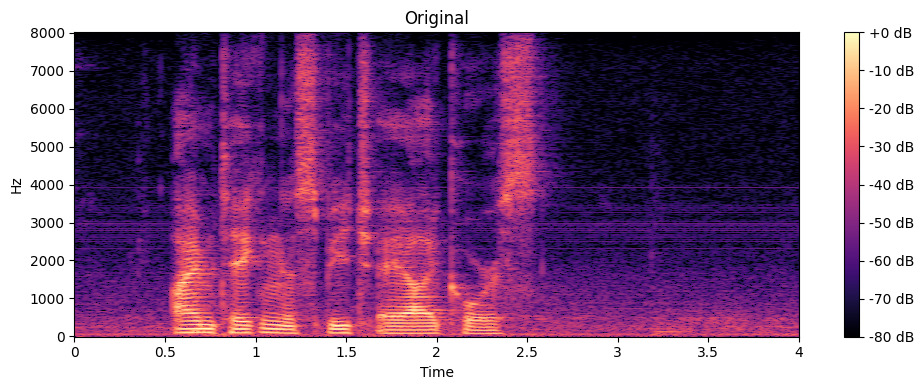

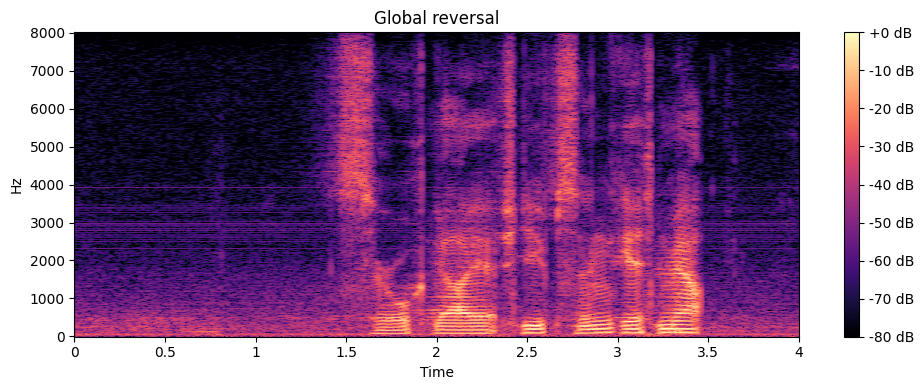

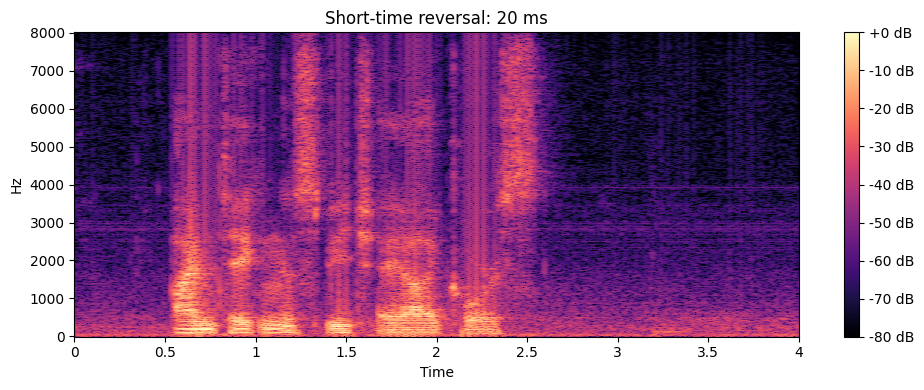

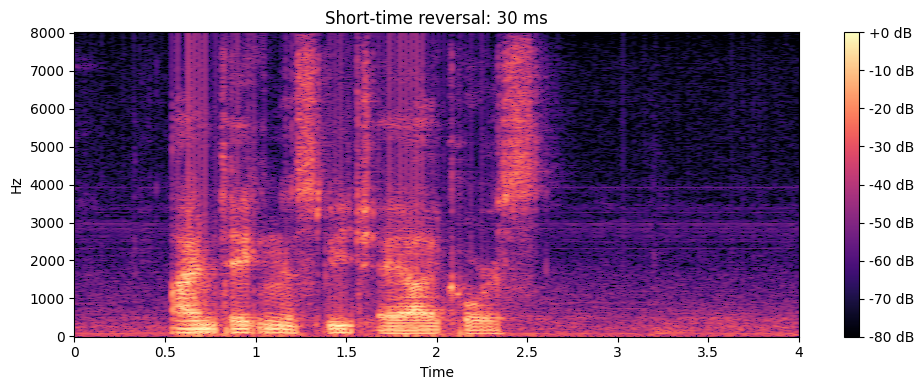

In [27]:
# TODO: Plot spectrograms (4 figures)
plot_spectrogram(x, fs, "Original")
plot_spectrogram(y_rev, fs, "Global reversal")
plot_spectrogram(y_str_20, fs, "Short-time reversal: 20 ms")
plot_spectrogram(y_str_30, fs, "Short-time reversal: 30 ms")


### Observations (Short-Time Reversal)

Answer in 10–14 lines total:

- Which is more intelligible: 20 ms or 30 ms short-time reversal? Why?
- Why is short-time reversal often **less destructive** than global reversal?
- What does this reveal about speech being “locally stationary” over short frames?
- What changed in the spectrograms vs the original?


- 20 ms is less destructible than 30 ms. This is because it preserves more of the transitions between phonemes.
- The 20 ms window also preserves more pitch harmonics and formant structure.
- Global reversal destroys temporal ordering completely but short-time reversal retains the frame order.
- This means that some of the ordering remains so the timing between different syllables may be somewhat intelligible.
- This means that order doesn't matter as much over short time periods. However, when we reverse large portion it will destroy intelligibility. This reveals that the ordering between a signal at a specific point in time is most relevant to shortly before and after.
- The x-axis (time) shifted but there were no changes to the other axes.

---

# 4. Connecting to Short-Time Processing Intuition

Write 8–12 lines:

- Why do we process speech in short frames (20–30 ms)?
- What assumptions are we making about speech within a frame?
- How did your reversal experiments support or challenge those assumptions?


### Answers

- We process in 20-30 ms because it preserves some temporal information without destroying intelligibility. If we can reverse 20-30 ms windows and still extract meaningful information then we can easily extract that information in forward ordering.
- We are assuming that the important phonemes that we use to segment speech start/end on the window. Since we don't overlap at all here we assume that each window in self sufficient and contains something meaningful on its own.
- They supported the assumption because not every frame contains something meaningful which led to a weird addition of noise. It didn't sound as robotic as the previous notebook but it added some non-human artifacts. This supports the assumption because the windows that were self sufficient led the remaining intelligbility while the others added noise.

---

# 5. Reflection (Mandatory)

Write thoughtful answers (be specific):

1. What did you learn that you did not expect about **delay/echo**?  
2. What was one surprising perceptual effect you noticed?  
3. Which visualization (waveform vs spectrogram) helped you explain what you heard—and why?  
4. If you had to explain “short-time processing” to a friend in 2–3 sentences, what would you say?  
5. What experiment would you try next (e.g., multiple echoes, feedback echo, overlap-add short-time reversal)?


1. I did not expect a short duration such as 50-100 ms so have such differing effects on echos.
2. I thought it was interesting that we could get the max possible value from echo with 1 + alpha since the alpha is the percent of the original signal.
3. The waveform helped me understand since we were reversing in the time domain. I didn't really find the spectrogram helpful.
4. I would say that we are processing small fragments of speech to extract relevant information. We use these size of windows because they are small enough to process easily and large enough to form intelligible speech.
5. I would try multiple echos next with different alpha values in a cascading format.

---

# 6. AI Use Disclosure (Required)

If you used any AI tools (including ChatGPT), briefly describe:
- What you used it for (e.g., debugging, concept clarification)
- What you wrote/changed yourself

*(If you did not use AI, write “No AI tools used.”)*


I used AI for the short time reversal and to understand some of the concepts.